# Imports and definitions

In [9]:
from utils import *
from paths_and_parameters import *

paths_to_create_delete = [path_figures]

first_n_peaks = 5

### Rotating the image clockwise at reading time: number of steps of 90 degrees ###
steps_rotation_photo = 0
steps_rotation_xrf = 2

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [4]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read and show photo of scanned section

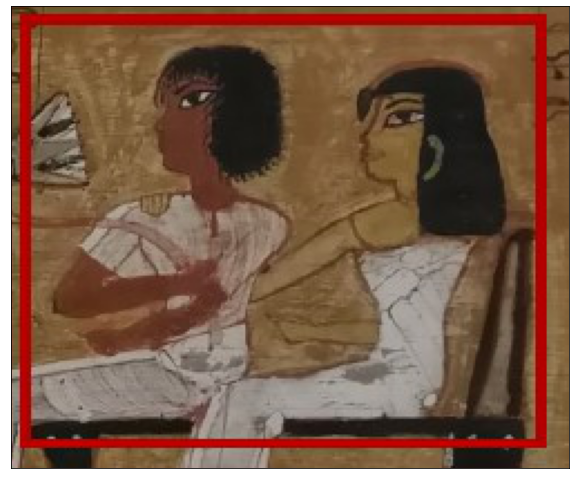

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    img_photo = Image.open(filename).transpose(1).rotate(90 * steps_rotation_photo, expand = True)
    fig, ax = subplots(figsize = (10, 10))
    ax.imshow(img_photo)
    ax.set_yticks([])
    ax.set_xticks([])
    show()

# Read XRF element maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [10]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_images)
data_xrf_elements.labels = flip(data_xrf_elements.labels, axis = xrf_axes_flip)
data_xrf_elements.rotate(steps_rotation_xrf)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print(f'Size of XRF scan: {data_xrf_elements.labels.shape[1], data_xrf_elements.labels.shape[0]}')

Found 15 images: images_Al_K, images_As_K, images_Ba_L, images_Ca_K, images_Cl_K, images_Cu_Ka, images_Cu_Kb, images_Fe_K, images_K_K, images_Mn_Ka, images_P_K, images_S_K, images_Si_K, images_Sr_K, images_Ti_K
Size of XRF scan: (114, 100)


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [11]:
qtl = 0.995
#qtl = 1

qtl_calculated = quantile(data_xrf_elements.labels, qtl, axis = (0, 1), keepdims = True)
n_corrected = (data_xrf_elements.labels > qtl_calculated).sum() / data_xrf_elements.labels.shape[-1]
data_xrf_elements.labels = clip(data_xrf_elements.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf_elements.labels.shape[0] * data_xrf_elements.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf_elements.labels -= data_xrf_elements.labels.min(axis = (0, 1), keepdims = True)

### Correct specific pixel ###
pixels_to_correct = []
#pixels_to_correct = [(0, 0)]
for x, y in pixels_to_correct:
    for i in range(data_xrf_elements.labels.shape[2]):
        data_xrf_elements.labels[y, x, i] = nanmin(data_xrf_elements.labels[..., i])

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

57 pixels out of 11400 were corrected on average in each XRF map.


# Explore XRF element maps

### All element maps

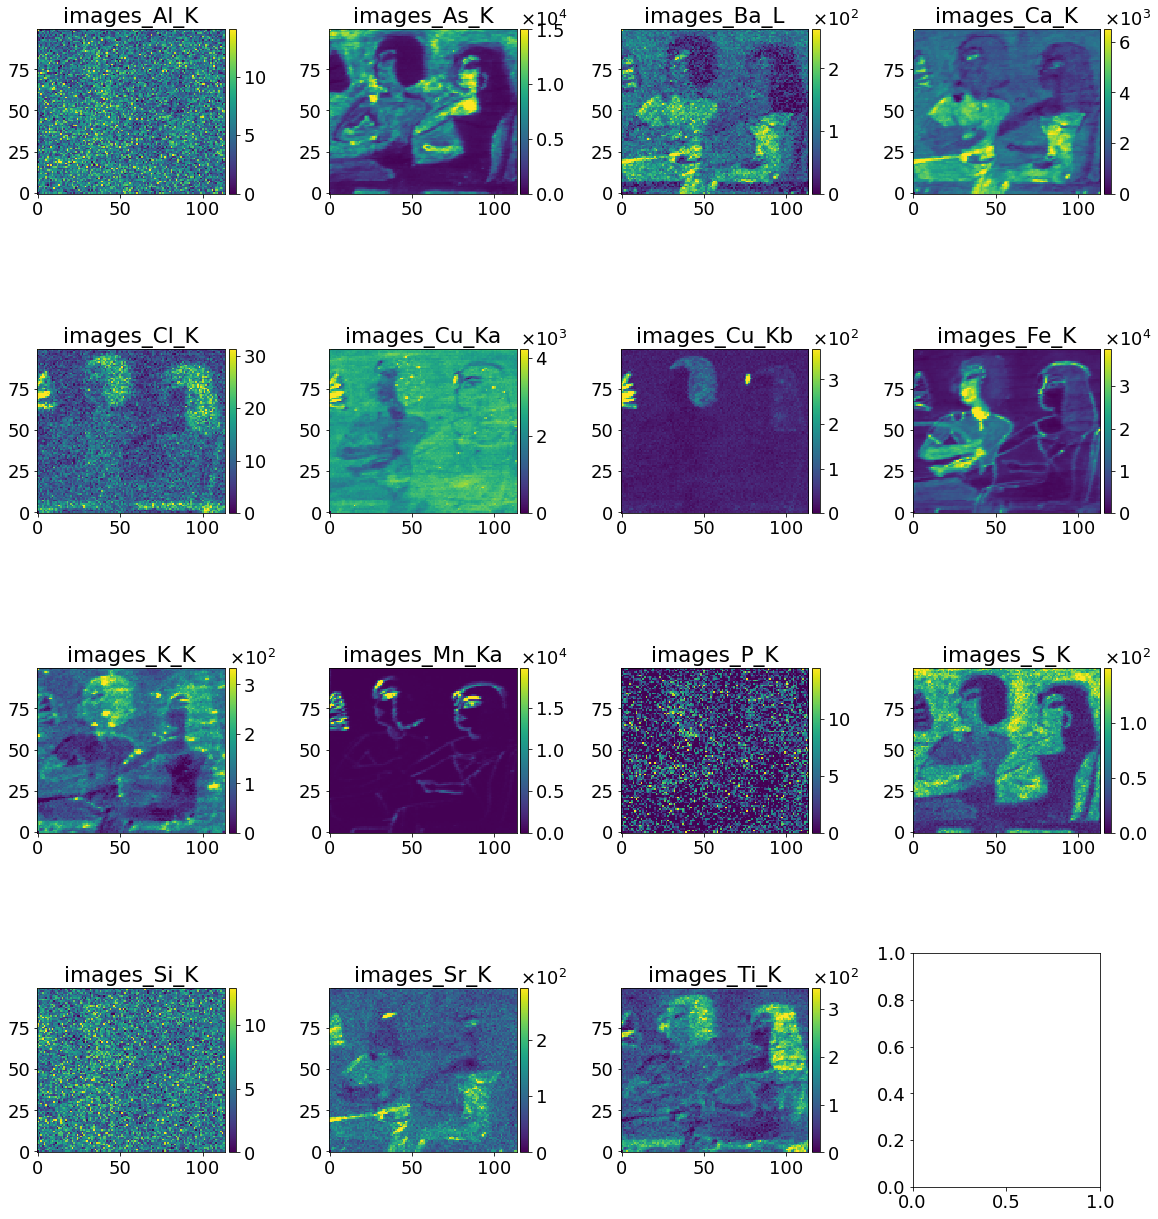

In [12]:
#%matplotlib qt
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf_elements.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 5 * n_of_rows * y_x_ratio))
fig.tight_layout(h_pad = 3, w_pad = 3)
for i, label in enumerate(data_xrf_elements.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf_elements.labels[..., i], interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

### Maps of selected element

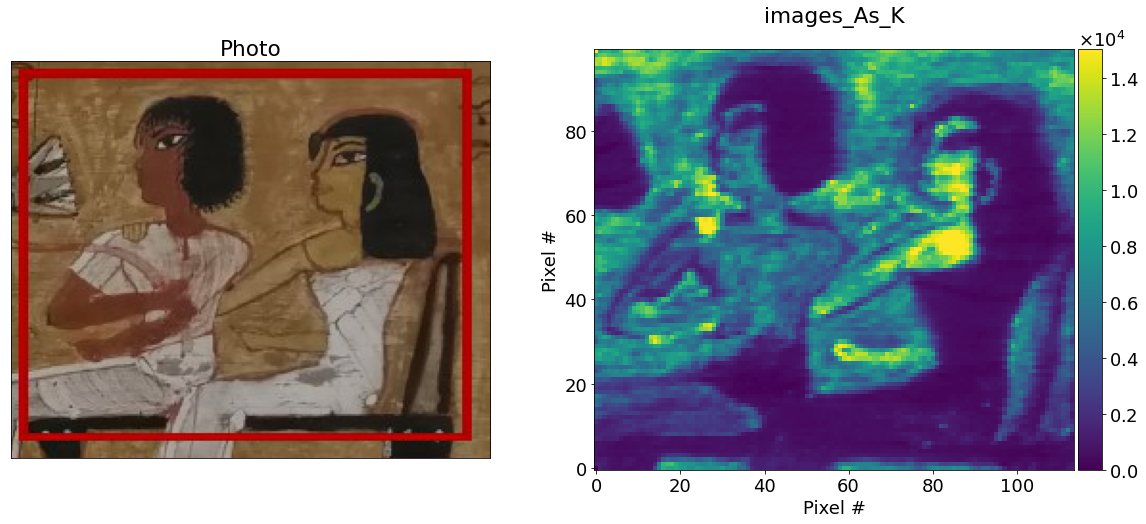

In [14]:
%matplotlib inline
#%matplotlib qt


rcParams['font.size'] = 18

element_chosen = 'As'

for i, label in enumerate(data_xrf_elements.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
        fig.tight_layout(w_pad = 3)

        ax = axs[0]
        ax.imshow(img_photo)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title('Photo')
        
        ax = axs[1]
        im = ax.imshow(data_xrf_elements.labels[..., i], interpolation = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.01, 0, 0.05, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_xlabel('Pixel #')
        ax.set_ylabel('Pixel #')
        ax.set_title(label, y = 1.05)

show()

### RGB map from 3 element maps

As:	images_As_K
Ca:	images_Ca_K
Cu:	images_Cu_Ka


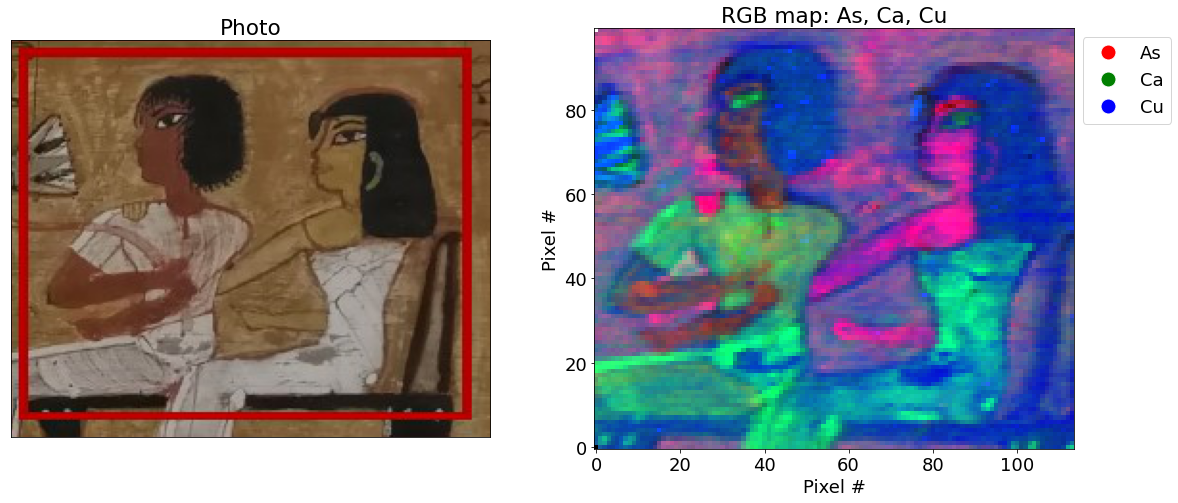

In [16]:
rcParams['font.size'] = 18
elements_chosen = ['As', 'Ca', 'Cu']
factors_intensity = [1, 1, 1]

check_find = [False] * 3
image_rgb = empty(list(data_xrf_elements.labels.shape[:2]) + [3])
for i, elem in enumerate(elements_chosen):
    j = find_element(elem, data_xrf_elements.metadata['labels'])
    if j is None:
        print(elem + ' not found.')
    else:
        print(elem + ':\t' + data_xrf_elements.metadata['labels'][j])
        check_find[i] = True
        image_rgb[..., i] = maps_xrf_norm[..., j].copy()

if all(check_find):
    image_rgb *= array(factors_intensity)[newaxis, newaxis, :]
    image_rgb = clip(image_rgb, 0, 1)

    fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
    fig.tight_layout(w_pad = 3)

    ax = axs[0]
    ax.imshow(img_photo)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Photo')
        
    ax = axs[1]
    im = ax.imshow(image_rgb, interpolation = 'none')
    legend_elements = [
        Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = c, markersize = 15, label = elements_chosen[i])
            for i, c in enumerate(['r', 'g', 'b'])
    ]
    ax.legend(handles = legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Pixel #')
    ax.set_title('RGB map: ' + ', '.join(elements_chosen))

    show()

extent = ax.get_tightbbox(fig.canvas.renderer).expanded(1.05, 1.05).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(path_figures + 'RGB_' + '_'.join(elements_chosen) + '.png', bbox_inches = extent)